<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/3.7%20Black%20Hole%20Spin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import numpy as np
import pylab
import math

import astropy.units as u
import matplotlib.pyplot as plt

from pycbc import waveform
from pycbc.waveform import get_td_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns

In [ ]:
## Taken from notebook 3.1 (updated redshift and duration)

def create_waveform(mass1=30, mass2=30, spin1=[0, 0, 0], spin2=[0, 0, 0], resolution=1.0/1024, frequencybound=20, distance=500, cosmology=Planck18):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1, mass2=mass2,
                                             spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                             spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Taken from notebook 3.2 (SNR expectation value without any noise)

def expectation_SNR(mass1, mass2, spin1, spin2, templatemass1, templatemass2, templatespin1, templatespin2, resolution, psdresolution, lowfreq, distance, psd, cosmology=Planck18):

  ## Create waveform 

  gwamp, gwtime = create_waveform(mass1=mass1, mass2=mass2, spin1=spin1, spin2=spin2, resolution=resolution, frequencybound=lowfreq, distance=distance, cosmology=cosmology)
  gwsignal = TimeSeries(gwamp, delta_t=resolution)
  gwsignalfreq = gwsignal.to_frequencyseries(delta_f = psdresolution)


  ## Create PSD 

  flen = int((1 / resolution) / (2 * psdresolution)) + 1

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, psdresolution, lowfreq)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, psdresolution, lowfreq)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, psdresolution, lowfreq)


  ## Create template

  template, _ = get_td_waveform(approximant="SEOBNRv4_opt", mass1=templatemass1, mass2=templatemass2, 
                                spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                delta_t=resolution, f_lower=lowfreq)
  templatefreq = template.to_frequencyseries(delta_f = psdresolution)


  ## Calculate SNR

  gwdata = gwsignalfreq + psdfreq
  snr = matched_filter(template=templatefreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=lowfreq)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## Create distance estimation function

def estimate_distance(snr, guess, alpha, iterations, mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, distance='param', psd='aLIGODesignSensitivityP1200087', cosmology=Planck18, progress='yes'): 
  
  if distance == 'param':
    pred = guess
    estimate = expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, pred, psd, cosmology)
    print("Initial guess: {}".format(estimate))

    for i in range(iterations):
      diff = snr - estimate
      pred = pred + alpha * diff
      estimate = expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, pred, psd, cosmology)
      if progress == 'yes':
        print("Iteration {}: SNR = {}, Distance = {}".format(i, estimate, pred))
    
  else: 
    print("Nothing to estimate: distance needs to be set to param")

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(pred, diff) 

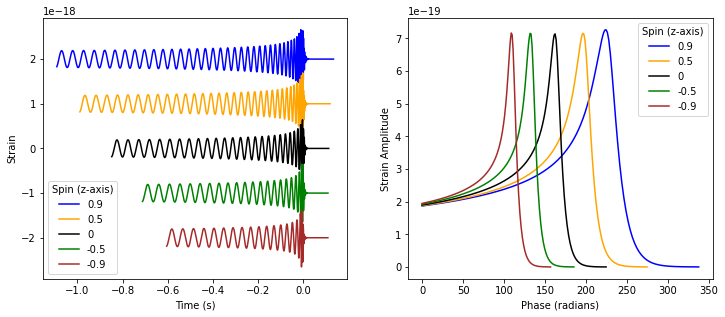

In [ ]:
## Determine the effect of spin on each of the three axes

normalamp, normaltime = create_waveform(distance=1)
spin5zamp, spin5ztime = create_waveform(spin1=[0, 0, 0.5], spin2=[0, 0, 0.5], distance=1)
spinneg5zamp, spinneg5ztime = create_waveform(spin1=[0, 0, -0.5], spin2=[0, 0, -0.5], distance=1)
spin9zamp, spin9ztime = create_waveform(spin1=[0, 0, 0.9], spin2=[0, 0, 0.9], distance=1)
spinneg9zamp, spinneg9ztime = create_waveform(spin1=[0, 0, -0.9], spin2=[0, 0, -0.9], distance=1)
## Unable to create waveforms with spin in the x- or y-axes

fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1,2,1)

plt.plot(spin9ztime, spin9zamp + 2 * 10**-18, color = "blue")
plt.plot(spin5ztime, spin5zamp + 1 * 10**-18, color = "orange")
plt.plot(normaltime, normalamp, color="black")
plt.plot(spinneg5ztime, spinneg5zamp - 1 * 10**-18, color = "green")
plt.plot(spinneg9ztime, spinneg9zamp - 2 * 10**-18, color = "brown")
plt.legend(labels=[0.9, 0.5, 0, -0.5, -0.9], title="Spin (z-axis)")
plt.ylabel("Strain")
plt.xlabel("Time (s)")

plt.subplot(1,2,2)

spins = [0.9, 0.5, 0, -0.5, -0.9]
colors = ["blue", "orange", "black", "green", "brown"]
for i in range(len(spins)):
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=30, mass2=30, spin1z=spins[i], spin2z=spins[i], delta_t=1.0/1024, f_lower=20)
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    pylab.plot(phase, amp, color = colors[i])

plt.legend(labels=[0.9, 0.5, 0, -0.5, -0.9], title="Spin (z-axis)")
plt.ylabel("Strain Amplitude")
plt.xlabel("Phase (radians)")
fig.show()

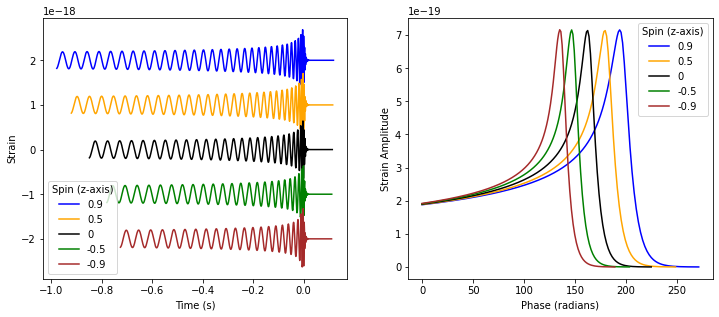

In [ ]:
## Repeat above, but only changing the spin of one black hole 

## Determine the effect of spin on each of the three axes

normalamp, normaltime = create_waveform(distance=1)
spin5zamp, spin5ztime = create_waveform(spin1=[0, 0, 0.5], distance=1)
spinneg5zamp, spinneg5ztime = create_waveform(spin1=[0, 0, -0.5], distance=1)
spin9zamp, spin9ztime = create_waveform(spin1=[0, 0, 0.9], distance=1)
spinneg9zamp, spinneg9ztime = create_waveform(spin1=[0, 0, -0.9], distance=1)
## Unable to create waveforms with spin in the x- or y-axes

fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1,2,1)

plt.plot(spin9ztime, spin9zamp + 2 * 10**-18, color = "blue")
plt.plot(spin5ztime, spin5zamp + 1 * 10**-18, color = "orange")
plt.plot(normaltime, normalamp, color="black")
plt.plot(spinneg5ztime, spinneg5zamp - 1 * 10**-18, color = "green")
plt.plot(spinneg9ztime, spinneg9zamp - 2 * 10**-18, color = "brown")
plt.legend(labels=[0.9, 0.5, 0, -0.5, -0.9], title="Spin (z-axis)")
plt.ylabel("Strain")
plt.xlabel("Time (s)")

plt.subplot(1,2,2)

spins = [0.9, 0.5, 0, -0.5, -0.9]
colors = ["blue", "orange", "black", "green", "brown"]
for i in range(len(spins)):
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=30, mass2=30, spin1z=spins[i], delta_t=1.0/1024, f_lower=20)
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    pylab.plot(phase, amp, color = colors[i])

plt.legend(labels=[0.9, 0.5, 0, -0.5, -0.9], title="Spin (z-axis)")
plt.ylabel("Strain Amplitude")
plt.xlabel("Phase (radians)")
fig.show()

In [ ]:
## Effect of spin on expectation SNR

distances = np.arange(100, 8000, 50)
spin9, spin5, spin0, spinneg5, spinneg9 = ([0] * len(distances) for i in range(5))

spins = [0.9, 0.5, 0, -0.5, -0.9]
snrlist = [spin9, spin5, spin0, spinneg5, spinneg9]


for i in range(len(snrlist)):
  for d in range(len(distances)):
    snrlist[i][d] = expectation_SNR(mass1=30, mass2=30, spin1=[0, 0, spins[i]], spin2=[0, 0, spins[i]],
                                    templatemass1=30, templatemass2=30, templatespin1=[0, 0, spins[i]], templatespin2=[0, 0, spins[i]],
                                    resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20, distance=distances[d], psd='aLIGODesignSensitivityP1200087')

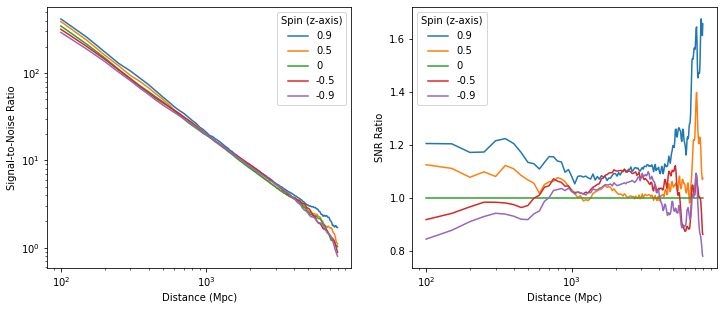

In [ ]:
distances = np.arange(100, 8000, 50)
                                                              
ratio9, ratio5, ratio0, rationeg5, rationeg9 = ([0] * len(distances) for i in range(5))
ratios = [ratio9, ratio5, ratio0, rationeg5, rationeg9]

for i in range(len(ratios)):
  for d in range(len(distances)):
    ratios[i][d] = snrlist[i][d] / spin0[d]

fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1,2,1)

for i in range(len(snrlist)):
  pylab.loglog(distances, snrlist[i])

pylab.ylabel("Signal-to-Noise Ratio")
pylab.xlabel("Distance (Mpc)")
pylab.legend(labels=spins, title="Spin (z-axis)")

plt.subplot(1,2,2)
for i in range(len(ratios)):
  pylab.plot(distances, ratios[i])

pylab.ylabel("SNR Ratio")
pylab.xlabel("Distance (Mpc)")
pylab.xscale('log')
pylab.legend(labels=spins, title="Spin (z-axis)")